# TME 9: Merge
> Consignes: le fichier TME8_Sujet.ipynb est à déposer sur le site Moodle de l'UE https://moodle-sciences.upmc.fr/moodle-2018/course/view.php?id=4650. Si vous êtes en binôme, renommez-le en TME8_nom1_nom2.ipynb.

N'oubliez pas de sauvegarder fréquemment votre notebook !!

## Données et codes utiles au TME

In [1]:
from PIL import Image
from pylab import *

### Données
img_test = full((64,64),150,dtype=uint8)
img_test[32:48,16:16+32] = 100
img_test[8:24,40:56] = 50
angio = array(Image.open('images/angiogra.png'))
cam = array(Image.open('images/cameraman.png'))
muscle = array(Image.open('images/muscle.png'))
prisme = array(Image.open('images/prisme.png'))
seiche = array(Image.open('images/seiche.png'))

### Fonction d'affichage
def affichage_14(affichages,titres=None):
    """ list[Array]*list[str] -> NoneType
    Dffectue entre 1 et 4 affichages avec leurs titres, pour des images ou courbes
    
    Paramètres :
      - liste des affichages (entre 1 et 4)
      - liste des titres (entre 1 et 4, autant que de affichages), optionnelle    
    """
    
    if not type(affichages) == type([]):
        affichages = [affichages]
        
    if titres is None:
        titres = ['',]*len(affichages)
        
    if not type(titres) == type([]):
        titres = [titres]
    
    nb_affichages = len(affichages)
    if nb_affichages >4 or nb_affichages < 1 :
        raise ValueError('affichage_14 nécéssite 1 à 4 entrées en paramètre')        
        
    if nb_affichages != len(titres):
        raise ValueError('affichage_14 nécéssite autant de titres que d\'affichages')
        
    courbes = False
    for i in range(0,nb_affichages):
        s = subplot(101+10*nb_affichages+i)
        s.set_title(titres[i])
        if len(affichages[i].shape)==2 and affichages[i].shape[0] > 1 and affichages[i].shape[1] > 1:
            # on affiche une image
            s.imshow(affichages[i], cmap="gray",interpolation='nearest', aspect='equal')
        else :
            # il s'agit d'une seule ligne, à afficher comme une courbe
            plot(affichages[i])
            courbes=True

    agrandissement_h = nb_affichages
    agrandissement_v = nb_affichages*2 if courbes else nb_affichages
    params = gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*agrandissement_v, plSize[1]*agrandissement_h) )
    show()



Recopier ci-dessous le code des fonctions ``split()``, ``predsplit1()`` et ``splitprof()``
écrites au TME 8:

In [2]:
def split(I,reg,pred,*args):
    """ Array*Bloc*(Array*Bloc*...->bool)*... -> 4-aire
        Découpage de I en arbre 4-aire sur un critère d'écart-type minimal
    """
    x,y,n,m = reg
    hx = n//2
    hy = m//2
    if pred(I,reg,*args) == True:
        NO = split(I,(x,y,hx,hy),pred,*args)
        NE = split(I,(x+hx,y,hx,hy),pred,*args)
        SO = split(I,(x,y+hy,hx,hy),pred,*args)
        SE = split(I,(x+hx,y+hy,hx,hy),pred,*args)
        return [NO,NE,SO,SE]
    else:
        return [reg]

def predsplit1(I,reg,*args):
    """ Array*Bloc*... -> bool
    """
    x,y,m,n = reg
    ecart_type = np.std(I[x:x+n,y:y+m])
    return ecart_type>args[0]

def splitprof(L):
    """ 4-aire -> list[Bloc]"""
    if len(L)==1:
        return L
    else:
        lst = []
        for f in L:
               lst=lst+splitprof(f)
        return lst

## Exercice 1
### Question 1
Modifier la fonction ``splitprof(L)`` pour en faire une fonction ``splitprofstat(L,I)`` qui rend une liste de feuilles de l'arbre 4-aire ``L`` et telle que chaque élément de cette liste, de type ``Bloc``, est enrichi de trois scalaires, le premier étant la taille, le second la moyenne et la troisième la variance des valeurs de pixels du bloc dans l'image ``I``. Cette fonction rend alors une liste dont les éléments ont pour type formel:
```python
type Blocstat = tuple[int**4,int,float**2]
```
Les quatre premières valeurs sont celles du type ``Bloc``, la cinquième est la taille du bloc (en nombre de pixels) et les deux dernières correspondent à la moyenne et la variance calculées sur la région.


In [3]:
# type Blocstat = tuple[int**4,int,float**2]

def splitprofstats(L,I):
    lst=splitprof(L)
    lst_1=[]
    for bloc in lst:
        x,y,n,m=bloc
        nb=n*m
        mu=np.mean(I[x:x+n,y:y+m])
        var=(np.std(I[x:x+n,y:y+m])**2)
        b=(x,y,n,m,nb,mu,var)
        lst_1.append(b)
    return lst_1


### Question 2
Dans la suite du TME, on considère le type formel:
```python
type Region = list[Blocstat]
```
Une région, comme vu au TME, est donc une liste de blocs. Écrire le prédicat de fusion ``predmerge(b,R,*args)`` vu en TD. Cette fonction retourne ```True``` si le bloc ``b`` doit fusionner dans la région ``R``. Si telle est le cas, alors le premier élément de la liste ``R`` voit ses statistiques modifiées: elles décrivent celles de l'ensemble des blocs de la région ainsi fusionnée.

In [9]:
def predmerge(b,R,*args):
    n1,mu1,var1=b[4:7]
    x,y,nr,mr,n2,mu2,var2=R[0]
    n=n1+n2
    mu=(n1*mu1+n2*mu2)/n
    var=((n1*(var1+mu1**2)+n2*(var2+mu2**2))/n)-mu**2
    if var<=args[0]:
        R[0]=(x,y,nr,mr,n,mu,var)
        return True
    else:
        return False


### Question 3
Implémenter les fonctions ```estdans()```, ```sontvoisins()```, ```voisins()``` et finalement ```merge()``` vues en TD.

In [19]:
def estdans(x,y,a):
    xa,ya,na,ma=a[0:4]
    return all([x>=xa,x<xa+na,y>=ya,y<ya+ma])

def sontvoisins(a,b):
    if b[2]<a[2] or b[3]<a[3]:
        a,b=b,a
    x,y,n,m=a[0:4]
    xc=x+n//2
    yc=y+m//2
    return any([estdans(xc+n,yc,b),estdans(xc-n,yc,b),estdans(xc,yc+m,b),estdans(xc,yc-m,b)])

def voisins(b,K):
    N=[]
    for n in K:
        if sontvoisins(n,b):
            N.append(n)
    return N    

# type Region = list[Blocstat]

def merge(S,I,pred,*args):
    L=[]
    while(len(S)>0):
        b=S[0]
        S=S[1:]
        R=[b]
        N=voisins(b,S)
        while(len(N)>0):
            bi=N[0]
            N=N[1:]
            if(pred(bi,R,*args)):
                R.append(bi)
                S.remove(bi)
                V=voisins(bi,S)
                for v in V:
                    if v not in N :
                        N.append(v)
        L.append(R)
    return L

### Question 4
Faire la mise au point des fonctions précédentes à l'aide de l'image ``img_test``.

In [21]:
reg=(0,0,img_test.shape[0],img_test.shape[1])
s=5
L=split(img_test,reg,predsplit1,s)
S=splitprofstats(L,img_test)
M=merge(S,img_test,predmerge,s)
print(M)

[[(0, 0, 32, 32, 3328, 150.0, 0.0), (32, 0, 16, 16, 256, 150.0, 0.0), (0, 32, 8, 8, 64, 150.0, 0.0), (8, 32, 8, 8, 64, 150.0, 0.0), (16, 32, 8, 8, 64, 150.0, 0.0), (24, 32, 8, 8, 64, 150.0, 0.0), (48, 0, 16, 16, 256, 150.0, 0.0), (0, 40, 8, 8, 64, 150.0, 0.0), (24, 40, 8, 8, 64, 150.0, 0.0), (48, 16, 16, 16, 256, 150.0, 0.0), (0, 48, 8, 8, 64, 150.0, 0.0), (24, 48, 8, 8, 64, 150.0, 0.0), (48, 32, 16, 16, 256, 150.0, 0.0), (0, 56, 8, 8, 64, 150.0, 0.0), (24, 56, 8, 8, 64, 150.0, 0.0), (32, 48, 16, 16, 256, 150.0, 0.0), (48, 48, 16, 16, 256, 150.0, 0.0), (8, 56, 8, 8, 64, 150.0, 0.0), (16, 56, 8, 8, 64, 150.0, 0.0)], [(32, 16, 16, 16, 512, 100.0, 0.0), (32, 32, 16, 16, 256, 100.0, 0.0)], [(8, 40, 8, 8, 256, 50.0, 0.0), (16, 40, 8, 8, 64, 50.0, 0.0), (8, 48, 8, 8, 64, 50.0, 0.0), (16, 48, 8, 8, 64, 50.0, 0.0)]]


### Question 5
Écrire une fonction ``regions(LR,shape)`` qui prend une liste de régions telle que rendu par la fonction ``merge()`` et rend une image des régions. Chaque région sera colorée avec le niveau de gris correspondant à la moyenne de la région. Le paramètre ``shape`` donne la taille de l'image à produire. Tester la fonction sur l'exemple précédent.

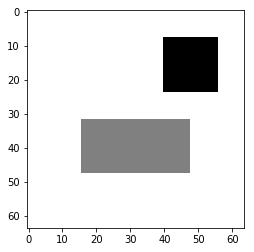

In [29]:
def regions(LR,shape):
    """ list[Region] -> Array """
    buf = zeros(shape,dtype=uint8)
    for R in LR:
        x,y,n,m,s,mu,v=R[0]
        for b in R:
            x,y,n,m,s,t,v=b
            buf[x:x+n,y:y+m] = int(mu)
    return buf



## Exercice 2: expérimentation
### Question 1:
Tester la fonction ``merge()`` sur les images ``angio``, ``cam``, ``muscle``, ``prisme`` et ``seiche``.

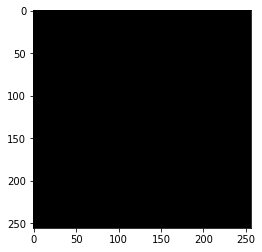

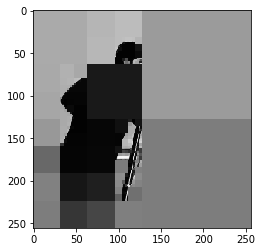

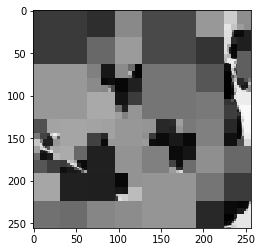

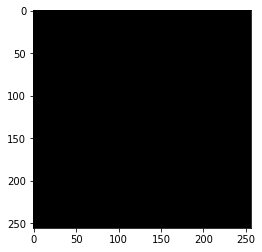

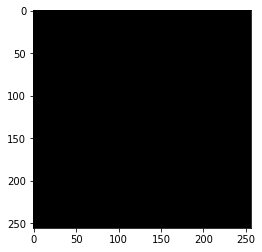

In [38]:
def test(I,s1,s2):
    reg=(0,0,I.shape[0],I.shape[1])
    L=split(I,reg,predsplit1,s1)
    S=splitprofstats(L,I)
    M=merge(S,I,predmerge,s2)
    regs = regions(M,I.shape)
    plt.figure()
    plt.imshow(regs)
    plt.gray()

s1=50
s2=5
test(angio,s1,s2)
test(cam,s1,s2)
test(muscle,s1,s2)
test(prisme,s1,s2)
test(seiche,s1,s2)

### Question 2 (bonus):
Utiliser un critère de découpage alternatif, par exemple celui proposé en cours: on fusionne qui la variance de la région fusionné est plus petite que celle de la région non fusionnée. Tester sur les images.

### Question 3 (bonus):
La fusion dépend de la façon dont on visite les régions. On peut alors faire un tri des feuilles de l'arbre 4-aire, par exemple, des blocs les plus gros aux plus petits, ou le contraire (utiliser la fonction Python ``sorted()``). La même question peut se poser lorsqu'on calcule l'ensemble des voisins de la région que l'on fusionne. Faut-il les trier ? Si oui, selon quel critère ? leur taille ? leur proximité ? Evidemment il n'y a pas de réponse universelle mais adaptée à chaque type de problème. Faites quelques tests pour voir l'influence de ces tris sur le résultat de la fusion.